data cleaning


In [2]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("data/dataset.csv", encoding="utf-8")

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (40, 22)


event_id            industry country initiating_company  \
0  EJP_ELEC_001  Electronics Retail   Japan         BIC Camera   
1  EJP_ELEC_002  Electronics Retail   Japan         BIC Camera   
2  EJP_ELEC_003  Electronics Retail   Japan         BIC Camera   
3  EJP_ELEC_004  Electronics Retail   Japan         BIC Camera   
4  EJP_ELEC_005  Electronics Retail   Japan         BIC Camera   

  responding_company  event_date    source_name  \
0   Yodobashi Camera  15-10-2018    Nikkei Asia   
1   Yodobashi Camera  01-04-2019  Asahi Shimbun   
2   Yodobashi Camera  01-12-2019    Japan Times   
3   Yodobashi Camera  12-05-2020       Mainichi   
4   Yodobashi Camera  18-11-2020    Nikkei Asia   

                                          source_url        action_type  \
0  https://asia.nikkei.com/Business/Retail/Bic-Ca...  Loyalty incentive   
1  https://www.asahi.com/articles/consumption-tax...   Price adjustment   
2  https://www.japantimes.co.jp/business/bic-wint...    Price promotion   
3      https://mainichi.jp/articles/bic-online-covid  Channel expansion   
4           https://asia.nikkei.com/Bic-Black-Friday    Price promotion   

                                  action_description  ... quantity_before  \
0  BIC increased point-back rates during autumn s...  ...        Standard   
1  Adjusted prices following Japan consumption ta...  ...        Standard   
2  BIC launched winter discount sale across TVs/a...  ...        Standard   
3  Expanded online discounts/delivery during COVI...  ...        Standard   
4  BIC increased promotional discounts for Black ...  ...        Standard   

  quantity_after response_observed                      response_type  \
0       Standard               Yes            Matched points campaign   
1       Standard               Yes          Parallel price adjustment   
2       Standard               Yes             Short-term discounting   
3  Home Delivery                No  Yodobashi retained logistics lead   
4       Standard               Yes         Promotional price matching   

  response_lag_days market_share_change_estimated  public_sentiment_shift  \
0               7.0                       Neutral                Positive   
1              14.0                       Neutral                 Neutral   
2              10.0                       Neutral                Positive   
3               NaN                       Neutral                Positive   
4               8.0                       Neutral                Positive   

  market_structure regulatory_sensitivity  \
0        Oligopoly                     No   
1        Oligopoly                    Yes   
2        Oligopoly                     No   
3        Oligopoly                     No   
4        Oligopoly                     No   

                                   notes  
0  Loyalty-based competitive escalation.  
1   Tax-driven industry-wide adjustment.  
2                Seasonal price rivalry.  
3             Pandemic-led digital push.  
4      Imported sales-event competition.  

[5 rows x 22 columns]

In [3]:
df = df_raw.copy()


In [4]:
missing_values = ["NA", "N/A", "", "None", "null"]
df.replace(missing_values, np.nan, inplace=True)

df.isna().sum()


event_id                          0
industry                          0
country                           0
initiating_company                0
responding_company                0
event_date                        0
source_name                       0
source_url                        0
action_type                       0
action_description                0
price_before                      6
price_after                       3
quantity_before                   3
quantity_after                    0
response_observed                 0
response_type                     0
response_lag_days                11
market_share_change_estimated     0
public_sentiment_shift            0
market_structure                  0
regulatory_sensitivity            0
notes                             0
dtype: int64

In [5]:
df["event_date"] = pd.to_datetime(
    df["event_date"],
    dayfirst=True,
    errors="coerce"
)


In [6]:
def yes_no_clean(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x == "yes":
        return 1
    if x == "no":
        return 0
    return np.nan

df["response_observed_bin"] = df["response_observed"].apply(yes_no_clean)
df["regulatory_sensitivity_bin"] = df["regulatory_sensitivity"].apply(yes_no_clean)

df[["response_observed", "response_observed_bin"]].head()


response_observed  response_observed_bin
0               Yes                      1
1               Yes                      1
2               Yes                      1
3                No                      0
4               Yes                      1

In [7]:
df["response_lag_days_num"] = pd.to_numeric(
    df["response_lag_days"],
    errors="coerce"
)


In [8]:
def price_type(x):
    if pd.isna(x):
        return "missing"
    x = str(x).lower()
    x = x.replace("â¥", "¥")  # encoding fix
    if "¥" in x:
        return "numeric"
    return x

df["price_before_type"] = df["price_before"].apply(price_type)
df["price_after_type"] = df["price_after"].apply(price_type)


In [9]:
df["quantity_after"] = df["quantity_after"].astype(str).str.lower().str.strip()

quantity_map = {
    "standard": 1,
    "bundle": 2,
    "seasonal": 3,
    "expanded": 4,
    "high speed": 4,
    "premium": 4
}

df["quantity_after_code"] = df["quantity_after"].map(quantity_map)


In [10]:
df["crisis_event"] = (
    df["notes"]
    .astype(str)
    .str.lower()
    .str.contains("covid|inflation|lockdown|tax")
)


In [11]:
text_cols = [
    "industry",
    "action_type",
    "response_type",
    "market_structure",
    "public_sentiment_shift"
]

for col in text_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()


In [12]:
df.info()

df["response_type"].value_counts()
df["response_observed_bin"].value_counts(dropna=False)
df["response_lag_days_num"].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   event_id                       40 non-null     object        
 1   industry                       40 non-null     object        
 2   country                        40 non-null     object        
 3   initiating_company             40 non-null     object        
 4   responding_company             40 non-null     object        
 5   event_date                     40 non-null     datetime64[ns]
 6   source_name                    40 non-null     object        
 7   source_url                     40 non-null     object        
 8   action_type                    40 non-null     object        
 9   action_description             40 non-null     object        
 10  price_before                   34 non-null     object        
 11  price_after          

count    29.000000
mean     12.275862
std       6.755403
min       0.000000
25%       7.000000
50%      10.000000
75%      15.000000
max      30.000000
Name: response_lag_days_num, dtype: float64

In [13]:
df.to_csv("data/cleaned_dataset.csv", index=False)
print("✅ Cleaned dataset saved to data/cleaned_dataset.csv")


✅ Cleaned dataset saved to data/cleaned_dataset.csv


In [14]:
df["response_type"].value_counts()
df["response_observed_bin"].value_counts(dropna=False)
df["price_before_type"].value_counts()


price_before_type
neutral       14
numeric       11
missing        6
standard       4
10% points     3
premium        2
Name: count, dtype: int64

EDA

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/cleaned_dataset.csv")


In [16]:
df.shape


(40, 29)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   event_id                       40 non-null     object 
 1   industry                       40 non-null     object 
 2   country                        40 non-null     object 
 3   initiating_company             40 non-null     object 
 4   responding_company             40 non-null     object 
 5   event_date                     40 non-null     object 
 6   source_name                    40 non-null     object 
 7   source_url                     40 non-null     object 
 8   action_type                    40 non-null     object 
 9   action_description             40 non-null     object 
 10  price_before                   34 non-null     object 
 11  price_after                    37 non-null     object 
 12  quantity_before                37 non-null     objec

In [18]:
df["response_type"].value_counts()


response_type
matched points campaign              2
promotional price matching           2
price match                          2
discount response                    2
service response                     2
digital coupon match                 2
parallel price adjustment            1
yodobashi focused on domestic        1
yodobashi retained logistics lead    1
short-term discounting               1
price matching                       1
service upgrade                      1
promotional match                    1
brand perception improved            1
competitive price pressure           1
minimal immediate reaction           1
digital coupon rollout               1
promotional response                 1
price response                       1
digital promotion response           1
service advantage strengthened       1
parallel price move                  1
value perception improved            1
matching takeout offers              1
delayed price hike                   1
increased f

In [19]:
pd.crosstab(
    df["action_type"],
    df["response_type"],
    normalize="index"
)


response_type         brand differentiation  brand perception improved  \
action_type                                                              
channel expansion                       0.0                        0.0   
covid response                          0.0                        0.0   
digital promotion                       0.0                        0.0   
logistics investment                    0.0                        0.0   
loyalty incentive                       0.0                        0.0   
menu expansion                          0.5                        0.0   
menu promotion                          0.0                        0.0   
new year promotion                      0.0                        0.0   
price adjustment                        0.0                        0.0   
price increase                          0.0                        0.0   
price promotion                         0.0                        0.0   
price reduction                         0.0                        0.0   
product strategy                        0.0                        0.0   
service enhancement                     0.0                        0.0   
service expansion                       0.0                        0.0   
store upgrade                           0.0                        1.0   

response_type         competitive price pressure  delayed price hike  \
action_type                                                            
channel expansion                            0.0                0.00   
covid response                               0.0                0.00   
digital promotion                            0.0                0.00   
logistics investment                         0.0                0.00   
loyalty incentive                            0.0                0.00   
menu expansion                               0.0                0.00   
menu promotion                               0.0                0.00   
new year promotion                           0.0                0.00   
price adjustment                             0.0                0.00   
price increase                               0.0                0.25   
price promotion                              0.0                0.00   
price reduction                              0.0                0.00   
product strategy                             0.5                0.00   
service enhancement                          0.0                0.00   
service expansion                            0.0                0.00   
store upgrade                                0.0                0.00   

response_type         delayed price response  digital coupon match  \
action_type                                                          
channel expansion                       0.00                   0.0   
covid response                          0.00                   0.0   
digital promotion                       0.00                   0.5   
logistics investment                    0.00                   0.0   
loyalty incentive                       0.00                   0.0   
menu expansion                          0.00                   0.0   
menu promotion                          0.00                   0.0   
new year promotion                      0.00                   0.0   
price adjustment                        0.00                   0.0   
price increase                          0.25                   0.0   
price promotion                         0.00                   0.0   
price reduction                         0.00                   0.0   
product strategy                        0.00                   0.0   
service enhancement                     0.00                   0.0   
service expansion                       0.00                   0.0   
store upgrade                           0.00                   0.0   

response_type         digital coupon rollout  digital promotion response  \
action_type                      

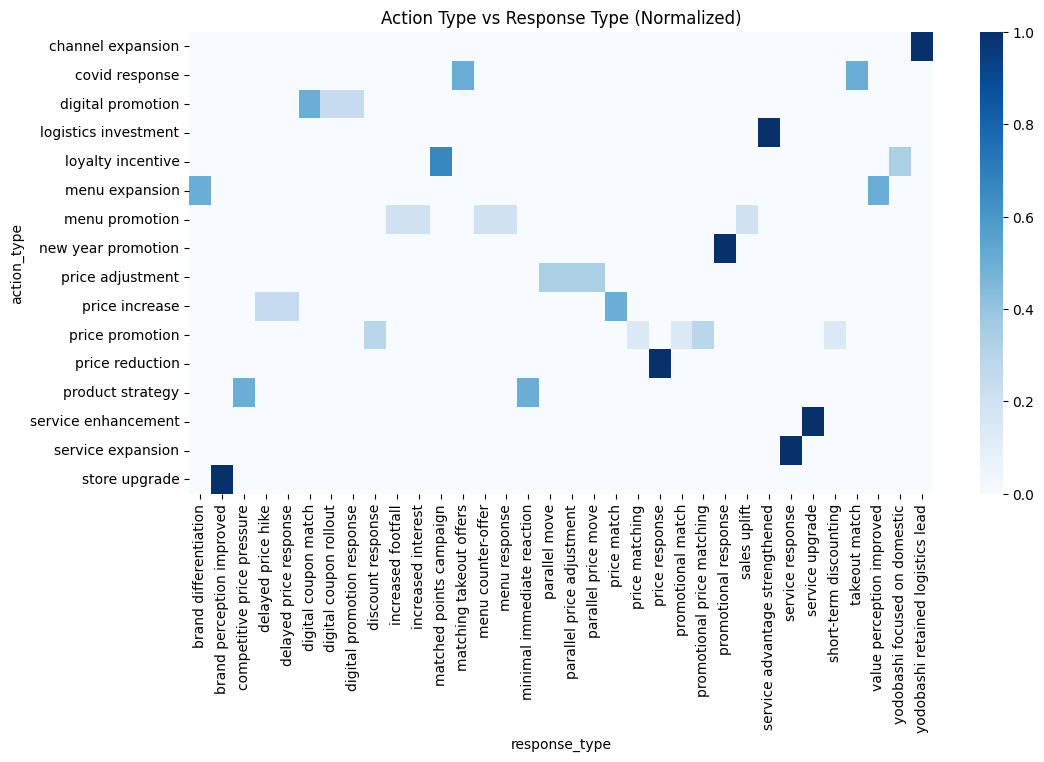

In [20]:
plt.figure(figsize=(12,6))
sns.heatmap(
    pd.crosstab(df["action_type"], df["response_type"], normalize="index"),
    cmap="Blues",
    annot=False
)
plt.title("Action Type vs Response Type (Normalized)")
plt.show()


In [21]:
pd.crosstab(df["crisis_event"], df["response_type"], normalize="index")


response_type  brand differentiation  brand perception improved  \
crisis_event                                                      
False                       0.027778                   0.027778   
True                        0.000000                   0.000000   

response_type  competitive price pressure  delayed price hike  \
crisis_event                                                    
False                            0.027778                0.00   
True                             0.000000                0.25   

response_type  delayed price response  digital coupon match  \
crisis_event                                                  
False                        0.027778              0.055556   
True                         0.000000              0.000000   

response_type  digital coupon rollout  digital promotion response  \
crisis_event                                                        
False                        0.027778                    0.027778   
True                         0.000000                    0.000000   

response_type  discount response  increased footfall  ...  \
crisis_event                                          ...   
False                   0.055556            0.027778  ...   
True                    0.000000            0.000000  ...   

response_type  promotional response  sales uplift  \
crisis_event                                        
False                      0.027778      0.027778   
True                       0.000000      0.000000   

response_type  service advantage strengthened  service response  \
crisis_event                                                      
False                                0.027778          0.055556   
True                                 0.000000          0.000000   

response_type  service upgrade  short-term discounting  takeout match  \
crisis_event                                                            
False                 0.027778                0.027778       0.027778   
True                  0.000000                0.000000       0.000000   

response_type  value perception improved  yodobashi focused on domestic  \
crisis_event                                                              
False                           0.027778                       0.027778   
True                            0.000000                       0.000000   

response_type  yodobashi retained logistics lead  
crisis_event                                      
False                                   0.027778  
True                                    0.000000  

[2 rows x 34 columns]

In [22]:
df["response_lag_days_num"].describe()


count    29.000000
mean     12.275862
std       6.755403
min       0.000000
25%       7.000000
50%      10.000000
75%      15.000000
max      30.000000
Name: response_lag_days_num, dtype: float64

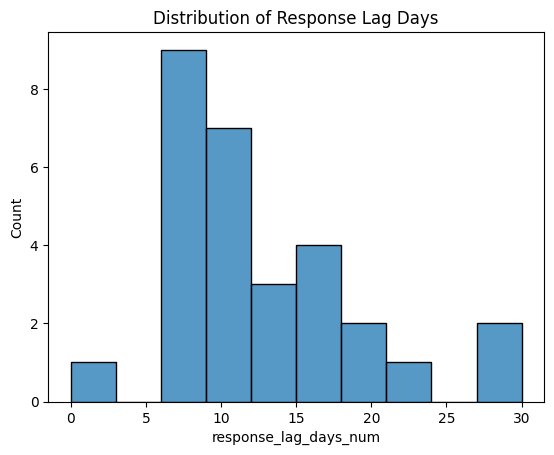

In [23]:
sns.histplot(df["response_lag_days_num"], bins=10)
plt.title("Distribution of Response Lag Days")
plt.show()


In [24]:
df["industry"].value_counts()


industry
electronics retail    20
food service          20
Name: count, dtype: int64

In [25]:
pd.crosstab(df["industry"], df["response_type"], normalize="index")


response_type       brand differentiation  brand perception improved  \
industry                                                               
electronics retail                   0.00                       0.05   
food service                         0.05                       0.00   

response_type       competitive price pressure  delayed price hike  \
industry                                                             
electronics retail                        0.05                0.00   
food service                              0.00                0.05   

response_type       delayed price response  digital coupon match  \
industry                                                           
electronics retail                    0.00                   0.0   
food service                          0.05                   0.1   

response_type       digital coupon rollout  digital promotion response  \
industry                                                                 
electronics retail                    0.05                        0.05   
food service                          0.00                        0.00   

response_type       discount response  increased footfall  ...  \
industry                                                   ...   
electronics retail                0.1                0.00  ...   
food service                      0.0                0.05  ...   

response_type       promotional response  sales uplift  \
industry                                                 
electronics retail                  0.05          0.00   
food service                        0.00          0.05   

response_type       service advantage strengthened  service response  \
industry                                                               
electronics retail                            0.05               0.0   
food service                                  0.00               0.1   

response_type       service upgrade  short-term discounting  takeout match  \
industry                                                                     
electronics retail             0.05                    0.05           0.00   
food service                   0.00                    0.00           0.05   

response_type       value perception improved  yodobashi focused on domestic  \
industry                                                                       
electronics retail                       0.00                           0.05   
food service                             0.05                           0.00   

response_type       yodobashi retained logistics lead  
industry                                               
electronics retail                               0.05  
food service                                     0.00  

[2 rows x 34 columns]

ML

In [26]:
counts = df["response_type"].value_counts()
valid_types = counts[counts >= 2].index

df_ml = df[df["response_type"].isin(valid_types)].copy()

df_ml["response_type"].value_counts()


response_type
matched points campaign       2
promotional price matching    2
discount response             2
service response              2
digital coupon match          2
price match                   2
Name: count, dtype: int64

In [27]:
features = [
    "industry",
    "action_type",
    "price_before_type",
    "price_after_type",
    "quantity_after_code",
    "market_structure",
    "regulatory_sensitivity_bin",
    "crisis_event"
]

X = df_ml[features]
y = df_ml["response_type"]


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)


In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


In [30]:
categorical = [
    "industry",
    "action_type",
    "price_before_type",
    "price_after_type",
    "market_structure"
]

numeric = [
    "quantity_after_code",
    "regulatory_sensitivity_bin",
    "crisis_event"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)


In [31]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)


In [32]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['industry', 'action_type',
                                                   'price_before_type',
                                                   'price_after_type',
                                                   'market_structure']),
                                                 ('num', 'passthrough',
                                                  ['quantity_after_code',
                                                   'regulatory_sensitivity_bin',
                                                   'crisis_event'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


                         precision    recall  f1-score   support

   digital coupon match       1.00      1.00      1.00         1
matched points campaign       1.00      1.00      1.00         1
       service response       1.00      1.00      1.00         1

               accuracy                           1.00         3
              macro avg       1.00      1.00      1.00         3
           weighted avg       1.00      1.00      1.00         3

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [34]:
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
importances = model.named_steps["clf"].feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


feature  importance
15       cat__price_after_type_neutral    0.082095
7    cat__price_before_type_10% points    0.072491
1           cat__industry_food service    0.062149
11     cat__price_before_type_standard    0.060012
5     cat__action_type_price promotion    0.059914
3   cat__action_type_loyalty incentive    0.059694
9       cat__price_before_type_neutral    0.058378
2   cat__action_type_digital promotion    0.055121
4      cat__action_type_price increase    0.054733
0     cat__industry_electronics retail    0.052365